## Imports

In [1]:
from __future__ import print_function
%matplotlib inline

import math
import os
import cv2
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Cropping2D, Lambda
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpim

Using TensorFlow backend.


## Utilities

In [2]:
def get_samples_list(sampledir, exclude=[], d_range=[]):
    samples = []
    labelcount = []
    for fname in os.listdir(sampledir):
        if fname[-4:]=='.png' and not fname[0] in exclude:
            d = int(fname.split('__')[-1].split('_')[0])
            if len(d_range) > 0 and (d < d_range[0] or d > d_range[1]):
                continue
            label = int(fname[0])
            samples.append((os.path.join(sampledir, fname), label))
            while len(labelcount) < label+1:
                labelcount += [0]
            labelcount[label] += 1
    print('label counts:')
    for i in range(len(labelcount)):
        print('{}: {}'.format(i, labelcount[i]))
    print('total: {}'.format(len(samples)))
    return samples

def augment_samples_list(samples, mult=[1, 1, 1], tx=[0, 0]):
    augs = []
    for sample in samples:
        x = mult[sample[1]]-1
        for i in range(x):
            shiftx = np.random.randint(tx[0], tx[1])
            shifty = np.random.randint(tx[0], tx[1])
            sample_aug = [sample[0], sample[1], shiftx, shifty]
            augs.append(sample_aug)
    return samples + augs

def datagen(samples, batch_size=32, n_class=4, grey=False):
    n_samples = len(samples)
    while True:
        samples = shuffle(samples)
        for offset in range(0, n_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            labels = []
            for batch_sample in batch_samples:
                im = mpim.imread(batch_sample[0])
                if grey:
                    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
                if len(batch_sample) > 2:
                    tx = batch_sample[2]
                    ty = batch_sample[3]
                    nrow, ncol = im.shape[:2]
                    T = np.float32([[1, 0, tx], [0, 1, ty]])
                    im = cv2.warpAffine(im, T, (ncol, nrow))
                images.append(im)
                labels.append(batch_sample[1])
                
            images = np.array(images)
            if grey:
                newshape = [x for x in images.shape] + [1]
                images = np.reshape(images, newshape)
            labels = keras.utils.to_categorical(np.array(labels), num_classes=n_class)
            
            yield shuffle(images, labels)
            
def count_sample_distro(samples):
    label_counts = []
    for sample in samples:
        label = sample[1]
        while len(label_counts) < label+1:
            label_counts += [0]
        label_counts[label] += 1
        
    total_count = sum(label_counts)
    max_count = max(label_counts)
    print('label counts, proportion, mult')
    for i, label in enumerate(label_counts):
        print('{} {:5.3f} {:6.2f}'.format(label, 1.0*label/total_count, 1.0*max_count/label))
    print('total', total_count)
    return label_counts

def get_samples_list_recursive(sample_root, exclude=[]):
    fnames = os.listdir(sample_root)
    samples = []
    for fname in fnames:
        if not (fname[0] in exclude) and fname[-4:] == '.png':
            samples.append([os.path.join(sample_root, fname), int(fname[0])])
        elif os.path.isdir(os.path.join(sample_root, fname)):
            new_root = os.path.join(sample_root, fname)
            add_samples = get_samples_list_recursive(new_root, exclude)
            samples += add_samples
    return samples            

def test_exhaustive(samples, model='model.h5', batch_size=32, grey=False):
    model = load_model(model)
    confusion = np.zeros((3, 3))
    
    N_bat = len(samples)//batch_size + 1
    for offset in range(0, len(samples), batch_size):
        print('batch', offset//batch_size+1, 'of', N_bat)
        labels = []
        imgs = []
        for sample in samples[offset:offset+batch_size]:
            img = mpim.imread(sample[0])
            if grey:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            labels.append(sample[1])

            if len(sample) > 2:
                tx = sample[2]
                ty = sample[3]
                T = np.float32([[1, 0, tx], [0, 1, ty]])
                nrow, ncol = img.shape[:2]
                img = cv2.warpAffine(img, T, (ncol, nrow))

            imgs.append(img)
        imgs = np.array(imgs)
        if grey:
            newshape = [x for x in imgs.shape] + [1]
            imgs = np.reshape(imgs, newshape)
        preds = model.predict(imgs)
        pred_labels = [int(np.argmax(pred)) for pred in preds]

        for label, pred_label in zip(labels, pred_labels):
            confusion[label][pred_label] += 1

    return confusion

## Sample generation test

In [3]:
samples = get_samples_list_recursive('samples', exclude=['3'])
samples = augment_samples_list(samples, mult=[1, 22, 4], tx=[-50, 51])
_ = count_sample_distro(samples)

label counts, proportion, mult
2233 0.337   1.00
2222 0.335   1.00
2172 0.328   1.03
total 6627


In [4]:
samplegen = datagen(samples, batch_size=10, n_class=3, grey=True)

(600, 800, 1)


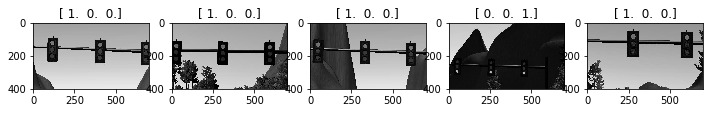

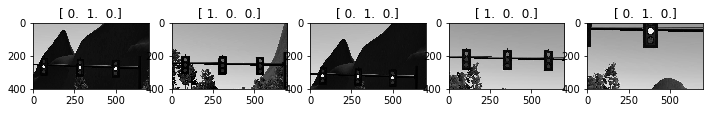

In [9]:
imgs, labels = next(samplegen)

grey = False
cropx = 50
cropy = 100

print(imgs[0].shape)

if imgs[0].shape[-1] < 3:
    grey = True
ncols = 5
for i, img in enumerate(imgs):
    if i % ncols == 0:
        plt.figure(figsize=(12, 12))
    plt.subplot(1, ncols, (i%ncols)+1)
    img = img[cropy:-cropy, cropx:-cropx]
    if grey:
        plt.imshow(np.squeeze(img), cmap='gray')
    else:
        plt.imshow(img)
#     plt.gca().set_xlim([0+50, 800-50])
#     plt.gca().set_ylim([0+100, 600-100])
    plt.gca().set_title(labels[i])

## Net definitions

In [10]:
def net_nvidia(n_class=4):
    model = Sequential()
    
    model.add(Cropping2D(((0, 0), (250, 250)), input_shape=(600, 800, 3)))
    
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2)))
    model.add(Activation('relu')) # the paper doesn't mention activation function, but isn't that needed?
    
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2)))
    model.add(Activation('relu')) 
    
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2)))
    model.add(Activation('relu')) 
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Activation('relu')) 
    
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1)))
    model.add(Dropout(0.30))
    model.add(Activation('relu')) 
    
    model.add(Flatten())
    
    model.add(Dense(100))
    model.add(Activation('relu'))
    
    model.add(Dense(50))
    model.add(Activation('relu'))
    
    model.add(Dense(10))
    model.add(Activation('relu'))
    
    model.add(Dense(n_class))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=1e-6), metrics=['accuracy'])
    
    return model

In [11]:
def net_simple(n_class=4):
    model = Sequential()
    
    model.add(Cropping2D((100, 250), input_shape=(600, 800, 3)))
    
    model.add(Conv2D(8, kernel_size=(5, 5)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(16, kernel_size=(5, 5)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, kernel_size=(5, 5)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    
    model.add(Dense(n_class))
    model.add(Activation('softmax'))
    
    model.compile(optimizer=Adam(lr=1e-6), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [12]:
def net2(n_class=3):
    model = Sequential()
    model.add(Cropping2D((100, 250), input_shape=(600, 800, 3)))
    
    model.add(Conv2D(16, kernel_size=(5, 5)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, kernel_size=(5, 5)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(256, kernel_size=(5, 5)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(Activation('relu'))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    
    model.add(Dense(n_class))
    model.add(Activation('softmax'))
    
    model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [13]:
def netgrey(n_class=3):
    model = Sequential()
    model.add(Cropping2D((100, 50), input_shape=(600, 800, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2))) # scale by half
    model.add(Lambda(lambda x: 2.0*x-1.0))
    
    model.add(Conv2D(8, kernel_size=(3, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    
    model.add(Conv2D(16, kernel_size=(5, 5)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))

    model.add(Flatten())
    
    model.add(Dropout(0.2))
    
#     model.add(Dense(256))
#     model.add(Activation('relu'))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    
    model.add(Dense(16))
    model.add(Activation('relu'))
    
    model.add(Dense(n_class))
    model.add(Activation('softmax'))
    
    model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [14]:
def train(model, sample_dir='samples', batch_size=8, epochs=1, grey=False):
    samples = get_samples_list_recursive(sample_dir, exclude=['3'])
    samples = augment_samples_list(samples, mult=[1, 20, 6], tx=[-20, 21])
    _ = count_sample_distro(samples)
        
    train_samples, valid_samples = train_test_split(samples, test_size=0.25)
    train_gen = datagen(train_samples, batch_size=batch_size, n_class=3, grey=grey)
    valid_gen = datagen(valid_samples, batch_size=batch_size, n_class=3, grey=grey)
    
    train_step = math.ceil(len(train_samples)/batch_size)
    valid_step = math.ceil(len(valid_samples)/batch_size)
    
    history = model.fit_generator(train_gen, steps_per_epoch=train_step,
                                  validation_data=valid_gen, validation_steps=valid_step,
                                  epochs=epochs, verbose=1)
    model.save('model.h5')
    return history

## Model training

In [15]:
model = netgrey(n_class=3)
h = train(model, batch_size=32, epochs=2, grey=True)

label counts, proportion, mult
2233 0.297   1.46
2020 0.269   1.61
3258 0.434   1.00
total 7511
Epoch 1/2
176/176 [==============================] - 198s - loss: 0.5386 - acc: 0.7994 - val_loss: 0.3111 - val_acc: 0.8777
Epoch 2/2
176/176 [==============================] - 218s - loss: 0.2081 - acc: 0.9173 - val_loss: 0.1708 - val_acc: 0.9300


In [19]:
model = load_model('model.h5')
model.summary()
h = train(model, batch_size=32, epochs=2, grey=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 400, 700, 1)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 200, 350, 1)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 200, 350, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 198, 348, 8)       80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 174, 8)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 99, 174, 8)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 95, 170, 16)       3216      
__________

## Testing result

In [21]:
samples = get_samples_list_recursive('samples', exclude=['3'])
# samples = augment_samples_list(samples, mult=[1, 22, 4], tx=[-50, 51])
_ = count_sample_distro(samples)

label counts, proportion, mult
2233 0.776   1.00
101 0.035  22.11
543 0.189   4.11
total 2877


In [22]:
conf = test_exhaustive(samples, model='model.h5', batch_size=64, grey=True)

batch 1 of 45
batch 2 of 45
batch 3 of 45
batch 4 of 45
batch 5 of 45
batch 6 of 45
batch 7 of 45
batch 8 of 45
batch 9 of 45
batch 10 of 45
batch 11 of 45
batch 12 of 45
batch 13 of 45
batch 14 of 45
batch 15 of 45
batch 16 of 45
batch 17 of 45
batch 18 of 45
batch 19 of 45
batch 20 of 45
batch 21 of 45
batch 22 of 45
batch 23 of 45
batch 24 of 45
batch 25 of 45
batch 26 of 45
batch 27 of 45
batch 28 of 45
batch 29 of 45
batch 30 of 45
batch 31 of 45
batch 32 of 45
batch 33 of 45
batch 34 of 45
batch 35 of 45
batch 36 of 45
batch 37 of 45
batch 38 of 45
batch 39 of 45
batch 40 of 45
batch 41 of 45
batch 42 of 45
batch 43 of 45
batch 44 of 45
batch 45 of 45


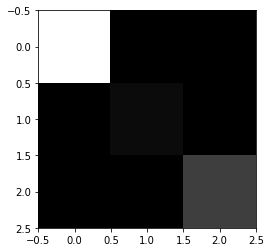

In [23]:
plt.imshow(conf, cmap='gray')

In [24]:
print(conf)
accuracy = sum([conf[i, i] for i in range(len(conf))])/sum(sum(conf))
print('accuracy', accuracy)

for i in range(len(conf)):
    print('class', i)
    precision = conf[i, i] / (sum(conf[:, i])) # true +ve / (true +ve + false +ve)
    recall = conf[i, i] / (sum(conf[i, :])) # true +ve / (true+ve + false -ve)
    print('precision', precision)
    print('recall', recall)
    print()

[[  2.22500000e+03   0.00000000e+00   8.00000000e+00]
 [  0.00000000e+00   1.01000000e+02   0.00000000e+00]
 [  2.00000000e+00   0.00000000e+00   5.41000000e+02]]
accuracy 0.996524157108
class 0
precision 0.999101930849
recall 0.996417375728

class 1
precision 1.0
recall 1.0

class 2
precision 0.985428051002
recall 0.996316758748



In [4]:
samples = get_samples_list('samples', exclude=['3'])
samples = augment_samples_list(samples, mult=[1, 150, 5])

label counts:
total: 0


In [74]:
samples_gen = datagen(samples, batch_size=32, n_class=3)

In [75]:
model = load_model('model_simple92.h5')

In [78]:
imgs, labels = next(samples_gen)
preds = model.predict(imgs, len(imgs), verbose=0)
# print(preds.shape)
# for pred, label in zip(preds, labels):
#     print(np.argmax(label), np.argmax(pred), pred)

good = 0
for label, pred in zip(labels, preds):
    if np.argmax(label) == np.argmax(pred):
        good += 1
print('accuracy', good/len(labels))

accuracy 0.90625


In [87]:
imx = mpim.imread('samples/0__21_1579319374_884872913.png')
imx = np.expand_dims(imx, axis=0)
print(imx.shape)
p = model.predict(imx)
print(np.argmax(p[0]), p[0])

(1, 600, 800, 3)
0 [0.72038025 0.1154097  0.16421007]


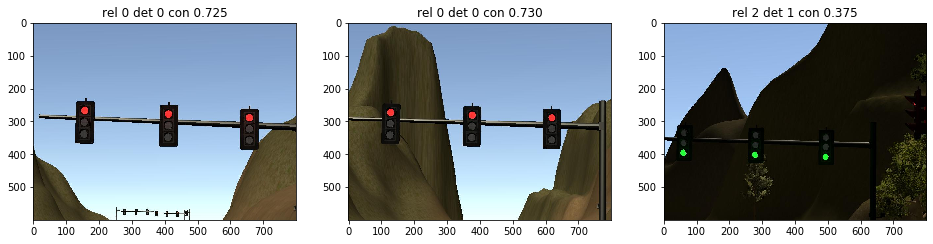

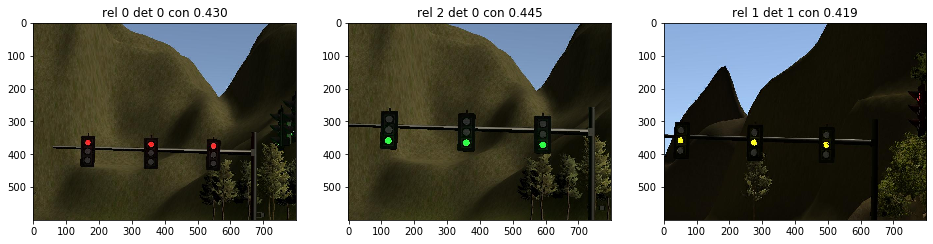

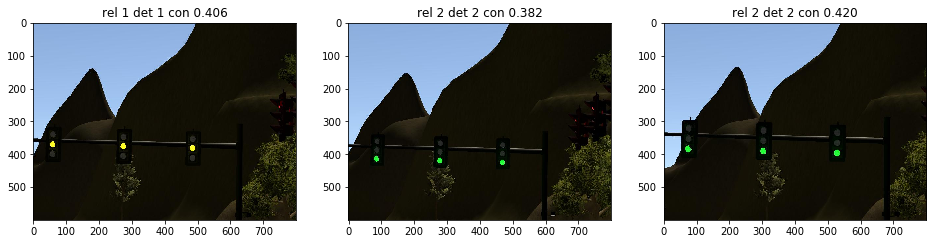

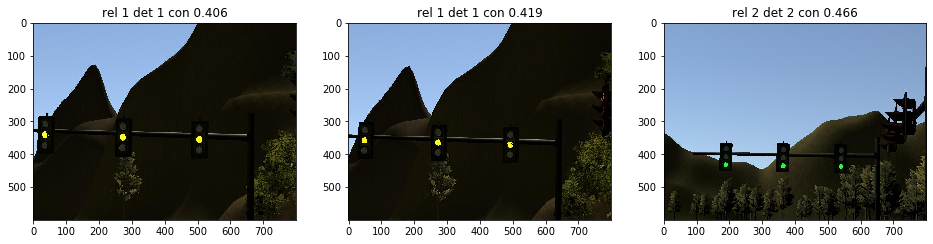

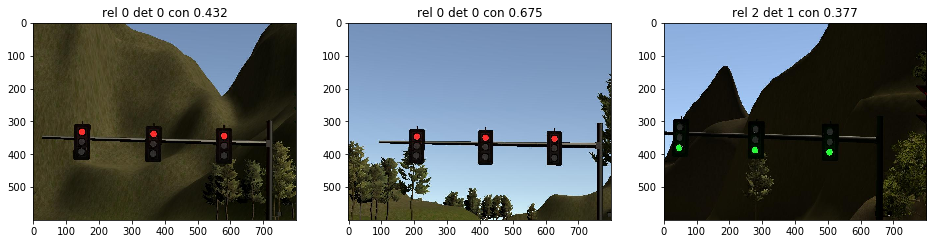

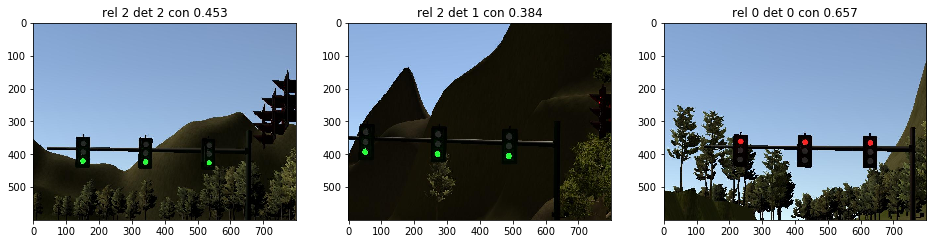

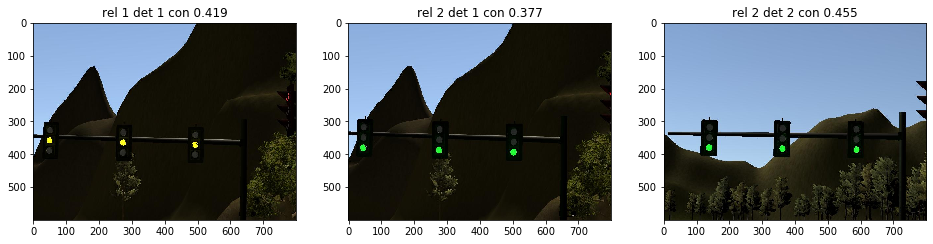

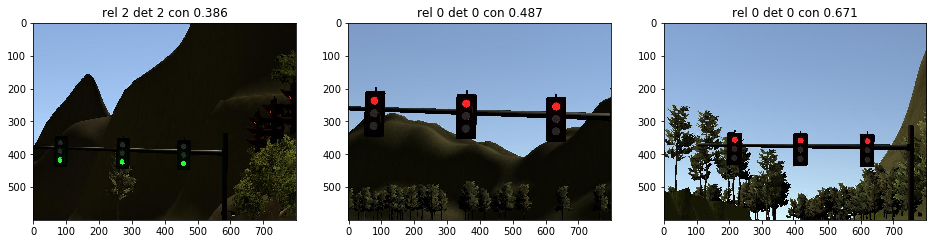

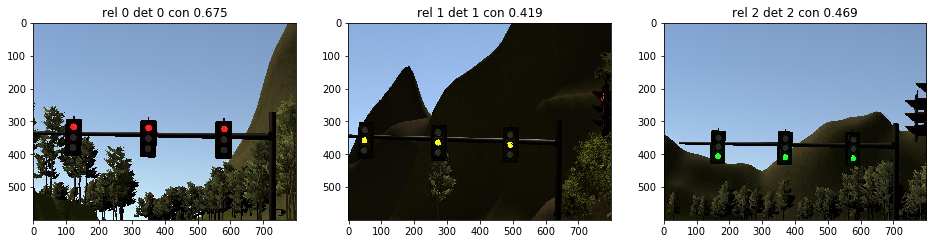

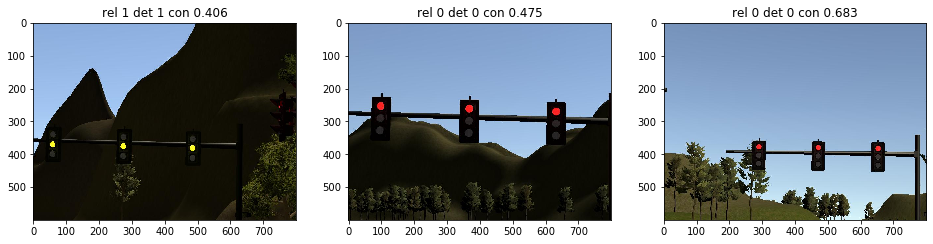

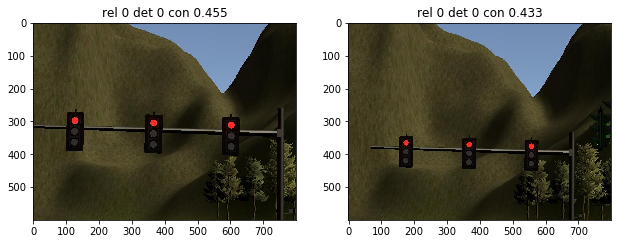

In [77]:
for i in range(0, len(imgs), 3):
    plt.figure(figsize=(16, 16))
    for j in range(3):
        if i + j < len(imgs):
            plt.subplot(1, 3, j+1)
            plt.imshow(imgs[i+j])
            real_class = np.argmax(labels[i+j])
            detect_class = np.argmax(preds[i+j])
            confidence = np.max(preds[i+j])
            plt.gca().set_title('rel {} det {} con {:5.3f}'\
                                .format(real_class, detect_class, confidence))